The goal here is to read in the HEALPix pixels for the modifed WFD footprint and create a skymap with RA, Dec labels (not doable with `healpy` so need to use the `mollweide` projection from `matplotlib`. We produce plots with:
- skymap with the proposed WFD and the all-band WFD footprint from `kraken2026`
- skymaps for just the baseline footprint and the new footprint
- skymap with baseline and proposed WFD footprint, with 4MOST and DESI

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import os
import healpy as hp
import numpy as np
import pandas as pd
from astropy.coordinates import SkyCoord
from astropy import units as u
import lsst.sims.maf.metricBundles as metricBundles
from matplotlib.lines import Line2D

In [2]:
fontsize = 16
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['axes.labelsize'] = fontsize
mpl.rcParams['xtick.labelsize'] = fontsize-2
mpl.rcParams['ytick.labelsize'] = fontsize-2
mpl.rcParams['legend.fontsize'] = fontsize-2
mpl.rcParams['axes.titlesize'] = fontsize
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['axes.grid'] = True
mpl.rcParams['figure.titlesize'] = fontsize

**Set up some things**

In [3]:
# data characteristics
nside = 256

# path for proposed WFD footprint
data_dir = '/global/homes/a/awan/desc/wfd_footprint/'
filepath = '%sWFDfootprint_nside%s_HEALPixels.csv'%(data_dir, nside)

# path + tags to read in coadd data for baseline2018a; saved data has masks for each band
file_yearTag = 'fullSurveyPeriod'
dbname = 'kraken_2026'
coadd_data_dir = '/global/cscratch1/sd/awan/lsst_output/coadd_output_allwps_perNight/'

**Read in the coadd data for the kraken_2026**

In [4]:
data_bundle = {}   
for band in ['u', 'g', 'r', 'i', 'z', 'y']:
    # set up the folders
    folder = 'coaddM5Analysis_nside%s_withDustExtinction_'%(nside)
    folder += '0pixelRadiusForMasking_%sBand_%s_%s_directory/'%(band, dbname, file_yearTag)
    path = '%s/%s/unmaskedCoaddData/'%(coadd_data_dir, folder)
    # get the filenames
    filenames = [f for f in os.listdir(path) if f.endswith('.npz')]
    print('Reading %s from\n%s/unmaskedCoaddData.\n'%(filenames, folder))

    if len(filenames)>1:
        err = 'Have more than one npz file for %s band'%band
        err += ' for %s data: %s'%(yr_cut, filenames)
        raise ValueError(err)
    else:
        dither = filenames[0].split('%s_'%band)[-1]
        dither = dither.split('.npz')[0]
        mB = metricBundles.createEmptyMetricBundle()
        mB.read('%s/%s'%(path, filenames[0]))
        data_bundle['%s'%(band)]= mB

Reading ['coaddM5Data_unmasked_u_RandomDitherPerNight.npz'] from
coaddM5Analysis_nside256_withDustExtinction_0pixelRadiusForMasking_uBand_kraken_2026_fullSurveyPeriod_directory//unmaskedCoaddData.

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Reading ['coaddM5Data_unmasked_g_RandomDitherPerNight.npz'] from
coaddM5Analysis_nside256_withDustExtinction_0pixelRadiusForMasking_gBand_kraken_2026_fullSurveyPeriod_directory//unmaskedCoaddData.

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Reading ['coaddM5Data_unmasked_r_RandomDitherPerNight.npz'] from
coaddM5Analysis_nside256_withDustExtinction_0pixelRadiusForMasking_rBand_kraken_2026_fullSurveyPeriod_directory//unmaskedCoaddData.

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Reading ['coaddM5Data_unmasked_i_RandomDitherPerNight.npz'] from
coaddM5Analysis_nside256_withDustExtinction_0pixelRadiusForMasking_iBand_kraken_2026_fullSurveyPeriod_directory//

**Find the all-band footprint for kraken_2026**

In [5]:
all_band_pixels = None

for band in data_bundle:
    index = np.where((data_bundle[band].metricValues.mask == False) & \
                     (data_bundle[band].metricValues.data > 0))[0]
    # save the indices
    if all_band_pixels is None:
        # initate the list
        all_band_pixels = index
    else:
        # keep only the overlapping pixels
        all_band_pixels = list(set(all_band_pixels).intersection(index))

**Plot the skymap for the all-band kraken_2026 WFD**

In [6]:
def get_area(pix_arr, nside):
    return len(pix_arr)*hp.nside2pixarea(nside=nside, degrees=True)

def plot_mollview(pix_list, nside, title_append=None):
    # set up the skymaps
    nPix = hp.nside2npix(nside)
    vals = np.zeros(nPix)+1.  # initiate all data to 1
    vals[pix_list] = 5000   # add fake data to the pixels in our list

    if title_append is not None:
        title = '%s\n%.2f deg2; nside %s'%(title_append,
                                           get_area(pix_list, nside),
                                           nside)
    else:
        title = '%.2f deg2; nside %s'%(get_area(pix_list, nside),
                                       nside)
    # plot the skymap
    plt.clf()
    hp.mollview(vals, flip='astro', rot=(0,0,0), min=0, max=10, title=title)
    hp.graticule(dpar=20, dmer=20, verbose=False)
    plt.show()

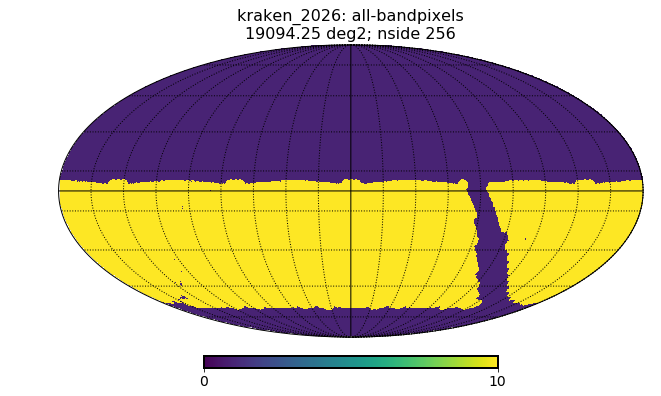

In [7]:
plot_mollview(pix_list=all_band_pixels, nside=nside,
              title_append='%s: all-bandpixels'%dbname)

**Now read in the pixel list for proposed WFD and plot the skymap**

## Reading in /global/homes/a/awan/desc/wfd_footprint/WFDfootprint_nside256_HEALPixels.csv


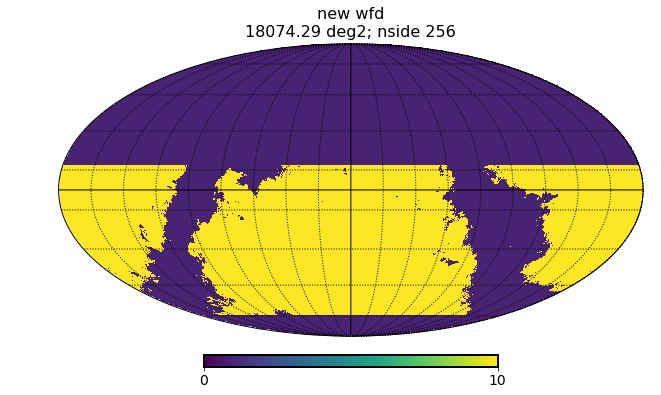

In [8]:
print('## Reading in %s'%filepath)
data = pd.read_csv(filepath)
# extract the pixel numbers
new_wfd_pixels = [int(f) for f in data['pixNum']]

plot_mollview(pix_list=new_wfd_pixels, nside=nside,
              title_append='new wfd')

**Okay, now lets create the mollweide skymaps using matplotlib** since we want to label ra, dec lines.

We use hp.pix2ang to get latitude, longitude corresponding to each pixel number. Then, pixel dec = np.pi/2 - latitude and ra = longitude.

In [9]:
def plot_matplot(pixels_dict, colors, alphas, titles, syms,
                 saveplot=False, fname=None):
    plt.figure()
    plt.subplot(111, projection="mollweide")

    # set up some plotting params
    size = 4.0
    
    if syms is None: syms = ['o']*len(colors)
    # ras, decs = {}, {}
    custom_lines, labels = [], []
    # loop over the pixels
    for i, pix_type in enumerate(pixels_dict):
        # convert healpix pixels to ra, dec values
        lat, ra = hp.pix2ang(ipix=pixels_dict[pix_type], nside=nside)
        ra = np.remainder(ra+np.pi*2, np.pi*2)
        dec = np.pi/2.0 - lat
        c = SkyCoord(ra=ra * u.radian, dec=dec * u.radian, frame='icrs')
        ra_rad = c.ra.wrap_at(180. * u.deg).radian
        dec_rad = c.dec.radian

        print('%s: %.2f <= dec <= %.2f'%(pix_type, min(np.degrees(dec_rad)),
                                         max(np.degrees(dec_rad))))
        # plot the ra, dec
        plt.scatter(-ra_rad, dec_rad, s=size, marker=syms[i], color=colors[i], alpha=alphas[i])
        
        custom_lines.append(Line2D([0], [0], color=colors[i], lw=10))
        labels.append('%s (%.f deg$^2$)'%(titles[i], get_area(pixels_dict[pix_type], nside)))
    # ---------------------------------------------
    # add legend/title
    if i==0:
        plt.title('%s (%.f deg$^2$)'%(titles[i],
                                      get_area(pixels_dict[pix_type], nside)),
                  y=1.05)
    else:
        if i==1:xcoord, ycoord = 0.95, 1.25
        elif i==2: xcoord, ycoord = 0.95, 1.35
        elif i==3: xcoord, ycoord = 0.9, 1.4
        else: xcoord, ycoord = 1., 1.25
        ax = plt.gca()
        ax.legend(custom_lines, labels, bbox_to_anchor=(xcoord, ycoord),
                  frameon=False, labelspacing=0.001)
    
    # ---------------------------------------------
    # relabel stuff: want RA increasing left-right
    locs, label = plt.xticks()
    labels = np.rad2deg(locs)
    print('\nOld labels: %s'%labels)
    labels[labels!=0] = -labels[labels!=0]
    print('News labels: %s'%labels)
    labels = [r'%.f$\degree$'%(f) for f in labels]
    plt.gca().set_xticklabels(labels)
    
    if saveplot:
        if fname is None:
            raise ValueError('Need fname to save plot.')
        else:
            plt.savefig(filename=fname, format='png', bbox_inches='tight')
            print('\n## Saved %s'%fname.split('/')[-1])
    
    plt.show()

baseline: -65.14 <= dec <= 5.83
new wfd: -69.98 <= dec <= 12.48

Old labels: [-150. -120.  -90.  -60.  -30.    0.   30.   60.   90.  120.  150.]
News labels: [ 150.  120.   90.   60.   30.    0.  -30.  -60.  -90. -120. -150.]

## Saved WFDfootprint_proposed_vs_kraken_2026_nside256_matplotlib.png


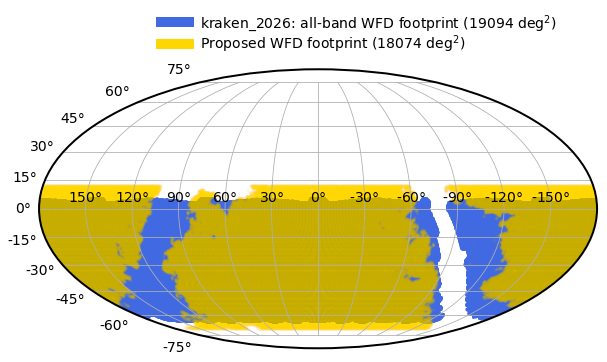

In [10]:
colors = ['royalblue', 'gold'] #  lightcoral, lightskyblue, darkviolet, rebeccapurple, maroon
alphas = [0.5, 0.03]
titles = ['%s: all-band WFD footprint'%dbname, 'Proposed WFD footprint']

filename = 'WFDfootprint_proposed_vs_%s_nside%s_matplotlib.png'%(dbname, nside)
filename='%s%s'%(data_dir, filename)

plot_matplot(pixels_dict={'baseline': all_band_pixels, 'new wfd': new_wfd_pixels},
             colors=colors, alphas=alphas, titles=titles, syms=None,
             saveplot=True, fname=filename)

**Lets also plot the skymaps individually**

kraken_2026: -65.14 <= dec <= 5.83

Old labels: [-150. -120.  -90.  -60.  -30.    0.   30.   60.   90.  120.  150.]
News labels: [ 150.  120.   90.   60.   30.    0.  -30.  -60.  -90. -120. -150.]

## Saved WFDfootprint_kraken_2026_nside256_matplotlib.png


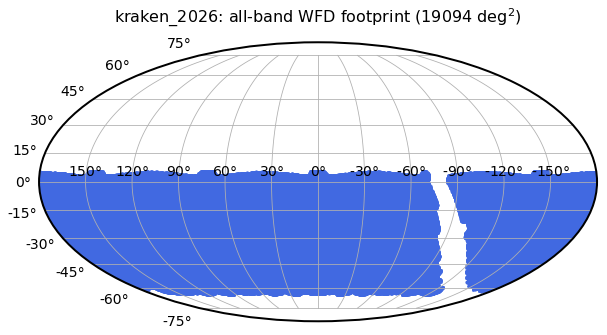

proposed: -69.98 <= dec <= 12.48

Old labels: [-150. -120.  -90.  -60.  -30.    0.   30.   60.   90.  120.  150.]
News labels: [ 150.  120.   90.   60.   30.    0.  -30.  -60.  -90. -120. -150.]

## Saved WFDfootprint_proposed_nside256_matplotlib.png


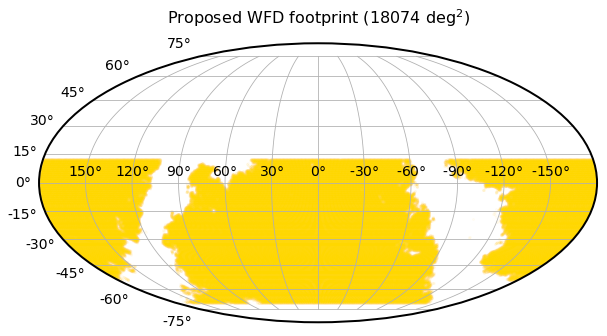

In [11]:
filetag = [dbname, 'proposed']
for i, pixs in enumerate([all_band_pixels, new_wfd_pixels]):
    
    filename = 'WFDfootprint_%s_nside%s_matplotlib.png'%(filetag[i], nside)
    filename='%s%s'%(data_dir, filename)

    plot_matplot(pixels_dict={filetag[i]: pixs}, syms=None,
                 colors=[colors[i]], alphas=[alphas[i]], titles=[titles[i]],
                 saveplot=True, fname=filename)

**Overplot things with 4MOST and DESI footprints**

In [12]:
footprint_pixels = {}

**Read in and plot the data**

In [13]:
# data dir for 4MOST and DESI footprints
# saved by the notebooks in static/depth_cuts/overlaps
footprint_dir = '/global/homes/a/awan/desc/4most_desi_data/'

# read in the footprints 
nsides = {}  # store so that we can up/down-grade maps if needed
for key in ['4MOST', 'DESI']:
    for i, file in enumerate([f for f in os.listdir(footprint_dir) if f.startswith(key) \
                              and f.__contains__('ring')]):
        if i>0: raise ValueError('Somethings wrong.')
        print('Reading %s'%file)
        nsides[key] = int(file.split('nside')[-1].split('_')[0])
        print('nside: %s'%nsides[key])
        footprint_pixels[key] = pd.read_csv('%s/%s'%(footprint_dir, file))['pixNum'].values

Reading 4MOST_pixels_nside16_ring.csv
nside: 16
Reading DESI_pixels_nside256_ring.csv
nside: 256


In [14]:
# lets see if need to degrade things if they are not at nside=256
for key in ['4MOST', 'DESI']:
    if nsides[key]!=nside:
        print('Changing %s footprint from nside %s to %s'%(key, nsides[key], nside))
        # create an array for hp.ud_grade
        npix = hp.nside2npix(nside=nsides[key])
        vals = np.zeros(npix)+5000  # random values
        footprint = vals.view(np.ma.MaskedArray)  # view as masked array
        footprint.mask = [True]*npix   # initialze as all masked
        footprint.mask[footprint_pixels[key]] = False   # unmask the footprint
    
        # now degrade
        footprint.fill_value = -100   # needed since hp will be doing some interp
        footprint = hp.ud_grade(footprint, nside_out=nside, pess=True)
        footprint_pixels[key] = np.where(footprint.data>5)[0]

Changing 4MOST footprint from nside 16 to 256


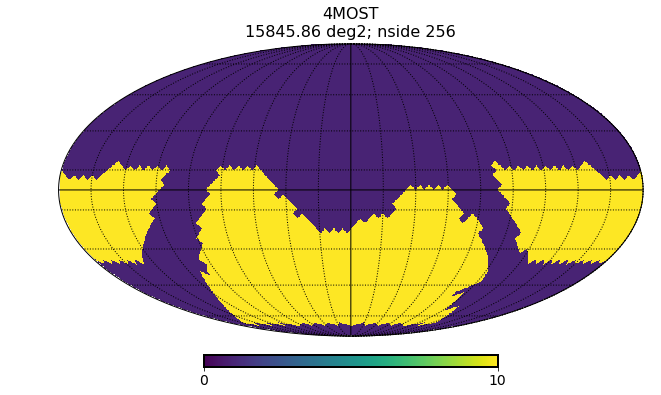

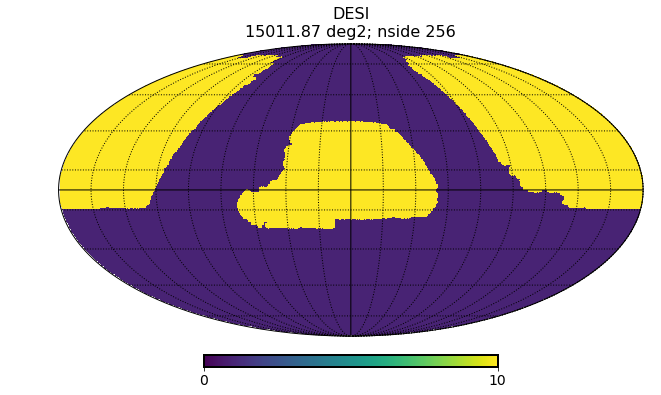

In [15]:
# lets plot the skymaps to check things
for key in footprint_pixels:
    if key.__contains__('4MOST') or key.__contains__('DESI'):
        plot_mollview(pix_list=footprint_pixels[key], nside=nside,
                      title_append=key)

**Plot and save the figure with everything plotted**

In [16]:
footprint_pixels['baseline'] = all_band_pixels
footprint_pixels['new wfd'] = new_wfd_pixels

4MOST: -78.10 <= dec <= 14.32
DESI: -19.79 <= dec <= 76.45
baseline: -65.14 <= dec <= 5.83
new wfd: -69.98 <= dec <= 12.48

Old labels: [-150. -120.  -90.  -60.  -30.    0.   30.   60.   90.  120.  150.]
News labels: [ 150.  120.   90.   60.   30.    0.  -30.  -60.  -90. -120. -150.]

## Saved WFDfootprint_proposed_vs_kraken_2026_vs_4MOST+DESI_nside256_matplotlib.png


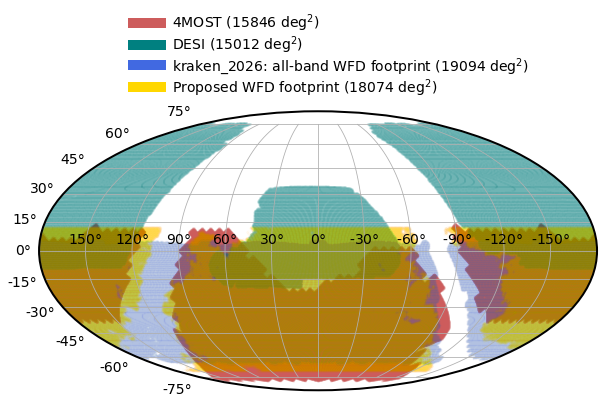

In [17]:
colors = ['indianred', 'teal', 'royalblue', 'gold']

alphas = [0.1, 0.03, 0.02, 0.015]
titles = ['4MOST', 'DESI', '%s: all-band WFD footprint'%dbname, 'Proposed WFD footprint']

filename = 'WFDfootprint_proposed_vs_%s_vs_4MOST+DESI_nside%s_matplotlib.png'%(dbname, nside)
filename='%s%s'%(data_dir, filename)

plot_matplot(pixels_dict=footprint_pixels, syms=['x', '_', '.', 'o'],
             colors=colors, alphas=alphas, titles=titles,
             saveplot=True, fname=filename)